In [10]:
import h5py
import pandas as pd
import geopandas as gpd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from shapely.geometry import Point
from pandas.io.json import json_normalize
import json
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
# from cartoframes.auth import set_default_credentials
# from cartoframes.viz import Map, Layer, basic_style, color_category_style, Layout, color_continuous_style
# # set_default_credentials('creds.json')

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:20,.2f}'.format
sns.set_context('paper', font_scale=1.5)
sns.set(rc={"lines.linewidth": 1.5})
sns.set_style('whitegrid')

In [11]:
scenarios = {
'01_na_n_mid':       {'name': 'Limited Access - Mod', 'technology': 'mod'},
'02_oa_o_mid':       {'name': 'Open Access - Mod', 'technology': 'mod'},
#'03_oa_o_low':       {'name': 'Open Access - Low', 'technology': 'low'},
#'04_oa_o_current':   {'name': 'Open Access - Current', 'technology': 'current'},
'05_b_b_mid':        {'name': 'Reference Access - Mod', 'technology': 'mod'},
'06_b_b_low':        {'name': 'Reference Access - Adv', 'technology': 'adv'},
'07_b_b_current':    {'name': 'Reference Access - Cur', 'technology': 'cur'},
#'08_b_bfdp_mid':    {'name': 'Reference Access Friction - Mod', 'technology': 'mod'},
#'09_b_bcwfd_mid':   {'name': 'Reference Access CWFD - Mid', 'technology': 'mid'},
#'10_b_l_current':    {'name': 'Legacy - Current', 'technology': 'current'},
#'11_sa_esacr_mid':   {'name': 'Existing Setbacks - Mid', 'technology': 'mid'},
#'12_sa_esemcr_mid':  {'name': 'Mid Setbacks - Mid', 'technology': 'mid'},
#'13_sa_esemcr_low':  {'name': 'Mid Setbacks - Low', 'technology': 'low'},
#'14_sa_esehcr_mid':  {'name': 'High Setbacks - Mid', 'technology': 'mid'},
#'15_sa_esehcr_low':  {'name': 'High Setbacks - Low', 'technology': 'low'},
#'16_tc_rl_mid':     {'name': 'Radar Limits - Mid', 'technology': 'mid'},
#'17_waec_sbc_mid':  {'name': 'Smart Bat Curtailment - Mid', 'technology': 'mid'},
#'18_waec_bbc_mid':  {'name': 'Blanket Bat Curtailment - Mid', 'technology': 'mid'},
#'19_waec_ndflr_mid': {'name': 'Fed Land Exclusion - Mid', 'technology': 'mid'}
}

In [12]:
core = ['Reference Access - Mod', 'Limited Access - Mod', 'Open Access - Mod']
base = ['Reference Access - Cur', 'Reference Access - Mod', 'Reference Access - Adv']
opena = ['Open Access - Cur', 'Open Access - Mod', 'Open Access - Adv']
friction = ['Reference Access Friction - Mod', 'Reference Access - Mod']

In [13]:
def custom_round(x, base=5):
    if pd.isna(x):
        return np.nan
    else:
        return int(base * round(float(x)/base))

def characterize(df):
    # Col cleanup
    df = df.drop(labels=['res_gids', 'gen_gids', 'gid_counts', 
                     'state', 'county', 'prairie_grouse', 'eagle',
                     'sc_row_ind', 'sc_col_ind', 'res_class',
                     'trans_gid', 'trans_capacity', 'country'], axis=1)
    try:
        df = df.drop(labels=['Unnamed: 0'], axis=1)
    except:
        pass
    # LCOE Bins
    df['site_lcoe_bin'] = df.mean_lcoe.apply(lambda x: custom_round(x, base=3))
    df['all_lcoe_bin'] = df.total_lcoe.apply(lambda x: custom_round(x, base=3))

    # Capacity Factor Bins
    df['cf_bin'] = df.mean_cf.apply(lambda x: custom_round(x*100, base=3)) / 100.

    # MW to GW
    df['gw'] = df.capacity / 1000.

    # Create the Setting
    df['setting'] = 'Land-Based'
    df.loc[df.sub_type=='fixed', 'setting'] = 'Offshore-Shallow'
    df.loc[df.sub_type=='floating', 'setting'] = 'Offshore-Deep'
    df = df.drop(labels=['offshore', 'sub_type'], axis=1) 

    # Capacity Bins for Farm Size
    df['capacity_bin_mw'] = df.capacity.apply(lambda x: custom_round(x, base=20))
    
    # Counties, ReEDS Regions, ReEDS BAs, States, Report Regions
    cnty = pd.read_csv('/scratch/alopez/deployment_scenarios/csv/county_to_regions.csv')
    df = df.merge(cnty, left_on='cnty_fips', right_on='fips', how='left')
    df = df.drop(labels=['cnty_fips_x', 'cnty_fips_y'], axis=1)
    
    # SC Population
    population = pd.read_csv('/scratch/alopez/deployment_scenarios/csv/population_scp.csv')
    df = df.merge(population[['sc_gid', 'population']], on='sc_gid', how='left')
    
    # Farm Sizes
    df['capacity_bin_mw'] = df.capacity.apply(lambda x: custom_round(x, base=20))
    
    # Wind Classes
    lbwc = [0, 5.87, 6.51, 7.08, 7.61, 8.07, 8.35, 8.57, 8.77, 9.01, 20]
    lbwl = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
    df['wind_class'] = pd.cut(df.mean_res, bins=lbwc, right=True, labels=lbwl)

    # remove offshore
    df = df[df.setting=='Land-Based']
    
    # offshore cable costs
    offca = pd.read_csv('/projects/rev/data/transmission/preliminary_orca_results_09042019_JN_gcb_capexmults.csv')
    
    # Cumulative Capacity
    df = df.sort_values('mean_lcoe')
    df['cum_cap_site_gw'] = df['capacity'].cumsum() / 1000.

    df = df.sort_values('total_lcoe')
    df['cum_cap_gw'] = df['capacity'].cumsum() / 1000.
    
    df = df.sort_values('lcot')
    df['cum_cap_lcot_gw'] = df['capacity'].cumsum() / 1000.
    
    # Generation
    df['mwh_mw'] = (df.mean_cf * df.capacity * 8760) / df.capacity
    df['mwh'] = df.mean_cf * df.capacity * 8760

    # Road Distance Bins
    df['road_bin_km'] = df.conus_roads_proximity_int32.apply(lambda x: custom_round(x, base=1000)) / 1000

    # Railroad Distance Bins
    df['rail_bin_km'] = df.conus_rail_90_proximity_int32.apply(lambda x: custom_round(x, base=1000)) / 1000
    
    df['count'] = 1
    
    # wind speed bin
    df['ws_bin'] = df.mean_res.apply(lambda x: round(x * 2) / 2)
        
    # $2015 TO $2018 
    for c in ['mean_lcoe', 'trans_cap_cost', 'lcot', 'total_lcoe']:
        df[c] = df[c] * 1.06059
        
    df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
    
    return df

In [14]:
dfs = []
d = '/shared-projects/rev/projects/weto/task_1/aggregation/'
#d = '/shared-projects/rev/projects/weto/task_1/aggregation/old_04232020/'
for abbrv, scenario in scenarios.items():
    print(scenario)
    df = pd.read_csv(d + abbrv + '/' + abbrv + '_sc.csv', low_memory=False)
    df = characterize(df)
    df['scenario'] = scenario['name']
    df['technology'] = scenario['technology']
    df['scenario_abbrv'] = abbrv
    #df[['latitude', 'longitude', 'gw', 'total_lcoe', 'mean_cf', ]].to_csv('/scratch/alopez/' + scenario['name'] + '.csv')
    dfs.append(df)
df = pd.concat(dfs, axis=0)

{'name': 'Limited Access - Mod', 'technology': 'mod'}


FileNotFoundError: [Errno 2] File /shared-projects/rev/projects/weto/task_1/aggregation/01_na_n_mid/01_na_n_mid_sc.csv does not exist: '/shared-projects/rev/projects/weto/task_1/aggregation/01_na_n_mid/01_na_n_mid_sc.csv'

In [199]:
dw = pd.read_csv('/shared-projects/rev/projects/weto/task_1/aggregation/09_b_bcwfd_mid/downwind/downwind_sc.csv', 
                low_memory=False)
dw = characterize(dw)
dw['scenario'] = 'Reference CWFD - Mod'
dw['technology'] = 'mod'
dw['scenario_abbrv'] = 'ref_cwfd'

ow = pd.read_csv('/shared-projects/rev/projects/weto/task_1/aggregation/09_b_bcwfd_mid/open_access/downwind/downwind_sc.csv', 
                low_memory=False)
ow = characterize(ow)
ow['scenario'] = 'Open Access CWFD - Mod'
ow['technology'] = 'mod'
ow['scenario_abbrv'] = 'oa_cwfd'

df = pd.concat([df, ow], axis=0)

In [188]:
df[df.scenario=='Reference Access - Adv'][['latitude', 'longitude', 'total_lcoe', 'lcot'
        ]].to_csv('paper/reference_access_adv.csv')

In [191]:
!gzip paper/reference_access_mod.csv

## Wind Site Size 

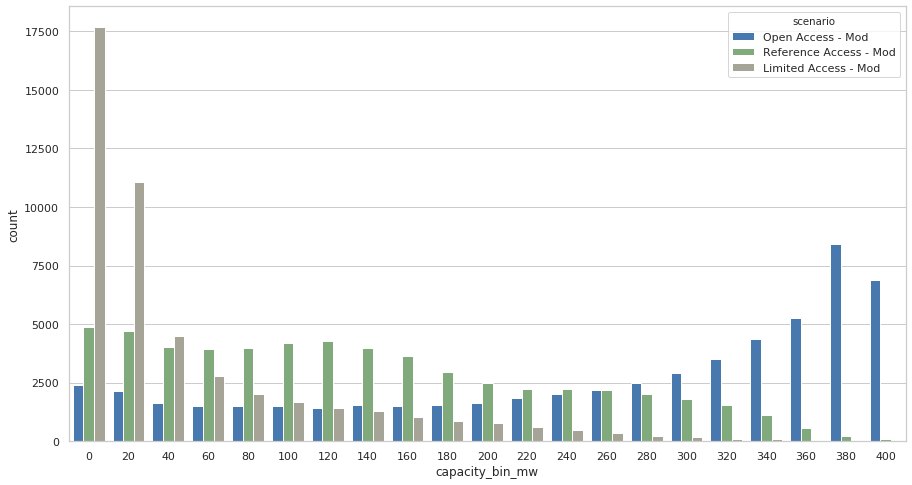

In [59]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.countplot(x='capacity_bin_mw', hue='scenario', data=t)

# Capacity / Generation Table

In [168]:
pd.DataFrame(df[((df.total_lcoe>0) & (df.scenario.isin(core)))].groupby(['scenario']).agg(
    {'gw': np.sum, 'mean_lcoe': np.mean, 'lcot': np.mean,
     'total_lcoe': np.mean, 'mwh': np.sum, 'count': np.sum, 'capacity': np.mean}).reset_index())

,scenario,gw,mean_lcoe,lcot,total_lcoe,mwh,count,capacity
0,Limited Access - Mod,"2,288.31",40.54,1.55,42.09,"7,357,395,541.89",47188,48.49
1,Open Access - Mod,"15,175.15",41.69,4.09,45.78,"47,717,439,813.00",58234,260.59
2,Reference Access - Mod,"7,827.26",41.23,2.96,44.20,"24,679,193,467.99",57123,137.02


In [8]:
with rasterio.open('/scratch/alopez/deployment_scenarios//templates/conus_template.tif', 'r') as src:
    meta = src.meta.copy()
    meta.update(compress='lzw')
    template_crs = src.crs.to_proj4()
    
cnty = gpd.read_file('/scratch/alopez/deployment_scenarios/templates/UScounties.shp')
cnty.rename(columns={'FIPS': 'fips'}, inplace=True)
cnty['fips'] = cnty.fips.astype(np.int)
regs = pd.read_csv('/scratch/alopez/deployment_scenarios/csv/county_to_regions.csv')
regs = regs[['fips', 'nrel_region']]
cnty = cnty.merge(regs, on='fips')
cnty = cnty.dissolve(by='nrel_region')
cnty = cnty.to_crs(template_crs)
cnty['gw'] = cnty.geometry.area / 1000000 * 3 / 1000
cnty = cnty.reset_index()
cnty = cnty[['nrel_region', 'gw']]
cnty['scenario'] = 'All Land'

t = df[df.scenario.isin(core)]
t = t.groupby(['nrel_region', 'scenario']).agg({'gw': sum}).reset_index()
t = pd.concat([cnty, t])

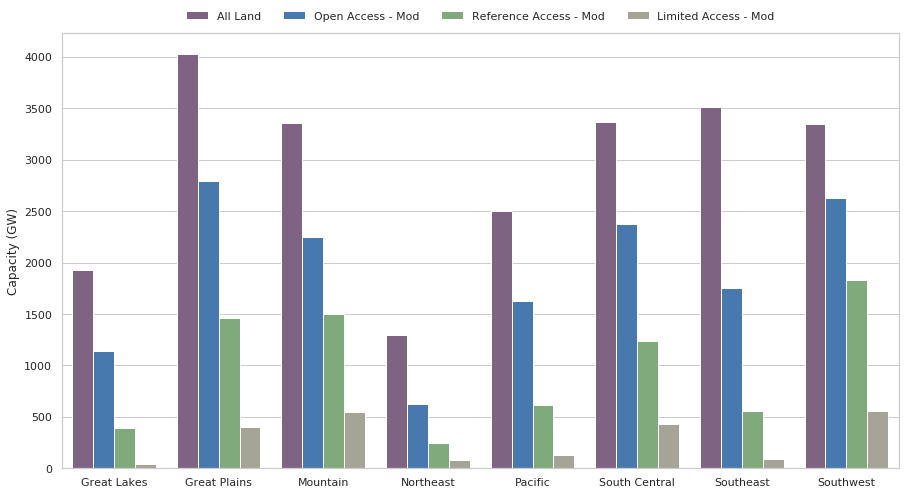

In [9]:
fig, ax = plt.subplots(figsize=(15, 8))
colors = ['dusty purple', 'windows blue', 'faded green', 'greyish']
sns.set_palette(sns.xkcd_palette(colors))

t['order'] = 1
t.loc[t.scenario=='Open Access - Mod', 'order'] = 2
t.loc[t.scenario=='Reference Access - Mod', 'order'] = 3
t.loc[t.scenario=='Limited Access - Mod', 'order'] = 4
t = t.sort_values(by=['order', 'nrel_region'])

g = sns.barplot(x='nrel_region', y='gw', hue='scenario', data=t, ci=None)
handles, labels = g.get_legend_handles_labels()
g.legend(loc='center', bbox_to_anchor=(0.5, 1.04), frameon=False, ncol=4, handles=handles[0:], labels=labels[0:])

_= g.set(ylabel='Capacity (GW)')
_= g.set(xlabel=None)

# Siting Regimes

### Capacity

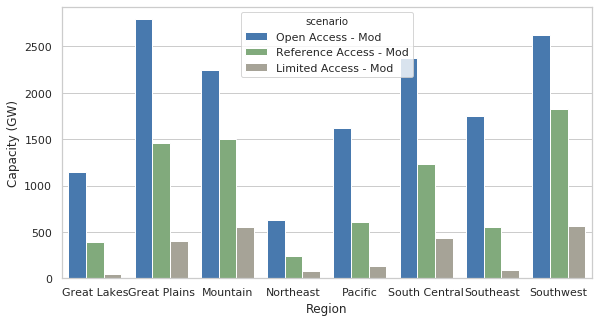

In [200]:
fig, ax = plt.subplots(figsize=(9.5, 5))
colors = ['windows blue', 'faded green', 'greyish', 'dusty purple']
sns.set_palette(sns.xkcd_palette(colors))

t = df[df.scenario.isin(core)]
t['order'] = 5
t.loc[t.scenario=='Open Access - Mod', 'order'] = 1
t.loc[t.scenario=='Reference Access - Mod', 'order'] = 2
t.loc[t.scenario=='Limited Access - Mod', 'order'] = 3

t = t.sort_values(by=['order', 'nrel_region'])
g = sns.barplot(x='nrel_region', y='gw', hue='scenario', data=t, estimator=sum, ci=None)

_= g.set(xlabel='Region')
_= g.set(ylabel='Capacity (GW)')

### Wind Speed

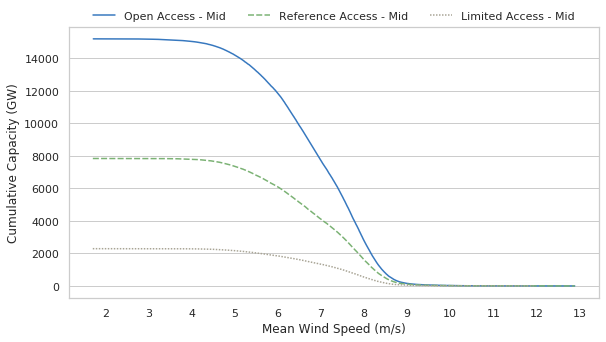

In [198]:
colors = ['windows blue', 'faded green', 'greyish']
sns.set_palette(sns.xkcd_palette(colors))

fig, ax = plt.subplots(figsize=(9.5, 5))

tl = []
for s in core:
    t = df[df.scenario.isin([s])]
    t.sort_values(by='mean_res', ascending=False, inplace=True)
    t['cum_gw_ws'] = t['capacity'].cumsum() / 1000.
    tl.append(t)
t = pd.concat(tl, axis=0)

t['order'] = 1
t.loc[t.scenario=='Open Access - Mid', 'order'] = 1
t.loc[t.scenario=='Reference Access - Mid', 'order'] = 2
t.loc[t.scenario=='Limited Access - Mid', 'order'] = 3
t = t.sort_values(by=['order', 'nrel_region'])
g = sns.lineplot(x='mean_res', y='cum_gw_ws', hue='scenario',
                 style='scenario', markers=False, data=t)

handles, labels = g.get_legend_handles_labels()
g.legend(loc='center', bbox_to_anchor=(0.5, 1.04), frameon=False, ncol=3, handles=handles[1:], labels=labels[1:])

_= ax.set(ylabel='Cumulative Capacity (GW)')
_= ax.set(xlabel='Mean Wind Speed (m/s)')
_= ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
_= ax.xaxis.grid(False)

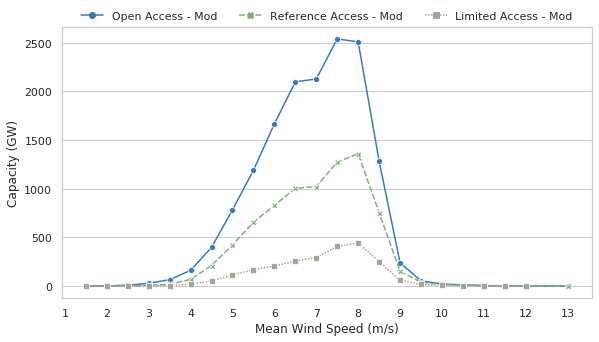

In [32]:
colors = ['windows blue', 'faded green', 'greyish', 'dusty purple']

sns.set_palette(sns.xkcd_palette(colors))

fig, ax = plt.subplots(figsize=(9.5, 5))

df['ws_bin'] = df.mean_res.apply(lambda x: round(x * 2) / 2)

t = df[df.scenario.isin(core)]
#t = df

t['order'] = 5
t.loc[t.scenario=='Open Access - Mod', 'order'] = 1
t.loc[t.scenario=='Reference Access - Mod', 'order'] = 2
t.loc[t.scenario=='Limited Access - Mod', 'order'] = 3

t = t.sort_values(by=['order', 'nrel_region'])
g = sns.lineplot(x='ws_bin', y='gw', hue='scenario',
                 style='scenario', markers=True, data=t, estimator=sum, ci=None)

handles, labels = g.get_legend_handles_labels()
#g.legend(loc='center', bbox_to_anchor=(0.5, 1.04), frameon=False, ncol=3, handles=handles[1:], labels=labels[1:])
g.legend(loc='center', bbox_to_anchor=(0.5, 1.04), frameon=False, ncol=4, handles=handles[1:], labels=labels[1:])

_= ax.set(ylabel='Capacity (GW)')
_= ax.set(xlabel='Mean Wind Speed (m/s)')
_= ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
_= ax.xaxis.grid(False)

In [95]:
a = df[df.scenario.isin(['Reference Access - Cur'])][['latitude', 'longitude', 'capacity', 'mwh', 'nrel_region', 'scenario']]
a.rename(columns={'capacity': 'cur_cap', 'mwh': 'cur_mwh'}, inplace=True)

b = df[df.scenario.isin(['Reference Access - Mod'])][['latitude', 'longitude', 'capacity', 'mwh']]
b.rename(columns={'capacity': 'mod_cap', 'mwh': 'mod_mwh'}, inplace=True)

c = df[df.scenario.isin(['Reference Access - Adv'])][['latitude', 'longitude', 'capacity', 'mwh']]
c.rename(columns={'capacity': 'adv_cap', 'mwh': 'adv_mwh'}, inplace=True)

d = a.merge(b, on=['latitude', 'longitude'])
d = d.merge(c, on=['latitude', 'longitude'])

In [100]:
d.to_csv('/home/alopez/notebooks/paper/wind_tech_cap_gen.csv')

In [97]:
d['mod_cur_cap_delta'] = d.mod_cap - d.cur_cap
d['adv_cur_cap_delta'] = d.adv_cap - d.cur_cap

d['mod_cur_mwh_delta'] = d.mod_mwh - d.cur_mwh
d['adv_cur_mwh_delta'] = d.adv_mwh - d.cur_mwh

In [36]:
t[['ws_bin', 'gw', 'scenario']].to_csv('/home/alopez/notebooks/paper/for_matt.csv')

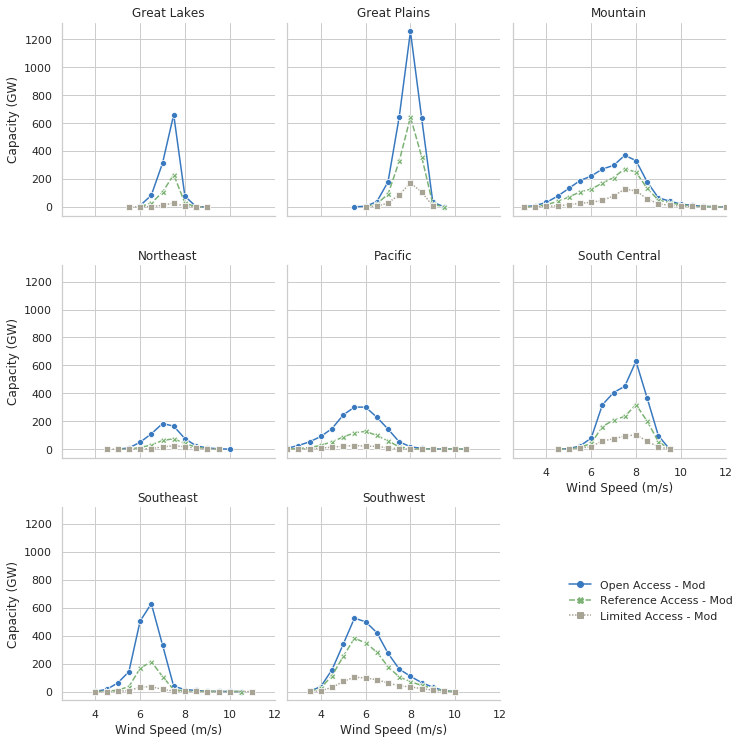

In [201]:
colors = ['windows blue', 'faded green', 'greyish', 'dusty purple']
sns.set_palette(sns.xkcd_palette(colors))

df['ws_bin'] = df.mean_res.apply(lambda x: round(x * 2) / 2)

t = df[df.scenario.isin(core)]

t['order'] = 5
t.loc[t.scenario=='Open Access - Mod', 'order'] = 1
t.loc[t.scenario=='Reference Access - Mod', 'order'] = 2
t.loc[t.scenario=='Limited Access - Mod', 'order'] = 3
t = t.sort_values(by=['order', 'nrel_region'])
g = sns.relplot(x='ws_bin', y='gw', hue='scenario', col='nrel_region', estimator=sum, ci=None,
                 style='scenario', markers=True, data=t, 
                kind='line', col_wrap=3, height=3.5)

leg = g._legend
leg.set_bbox_to_anchor([0.80, 0.2])
g._legend.texts[0].set_text("")

g.set_titles(template='{col_name}')

_= g.set(ylabel='Capacity (GW)')
_= g.set(xlabel='Wind Speed (m/s)')
_= g.set(xlim=(2.5,12))

g.savefig('paper/siting_wind_speed.svg')

### LCOT

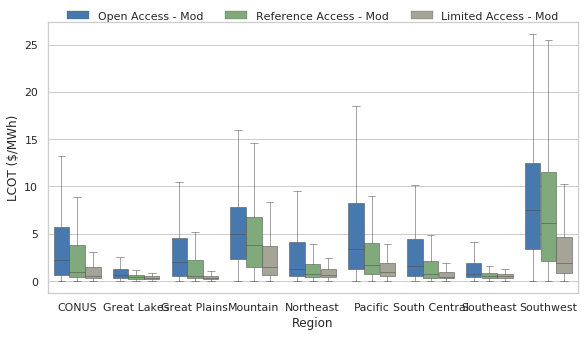

In [171]:
colors = ['windows blue', 'faded green', 'greyish', 'dusty purple']
sns.set_palette(sns.xkcd_palette(colors))

fig, ax = plt.subplots(figsize=(9.5, 5))

t = df[df.scenario.isin(core)]

a = t[t.scenario==core[0]]
a['nrel_region'] = 'CONUS'

b = t[t.scenario==core[1]]
b['nrel_region'] = 'CONUS'

c = t[t.scenario==core[2]]
c['nrel_region'] = 'CONUS'

t = pd.concat([t, a, b, c])

t['order'] = 5
t.loc[t.scenario=='Open Access - Mod', 'order'] = 1
t.loc[t.scenario=='Reference Access - Mod', 'order'] = 2
t.loc[t.scenario=='Limited Access - Mod', 'order'] = 3

t = t.sort_values(by=['order', 'nrel_region'])
g = sns.boxplot(x='nrel_region', y='lcot', hue='scenario', data=t[t.total_lcoe>0], showfliers=False,
               linewidth=0.5)

handles, labels = g.get_legend_handles_labels()
g.legend(loc='center', bbox_to_anchor=(0.5, 1.02), frameon=False, ncol=4)

_= ax.set(ylabel='LCOT ($/MWh)')
_= ax.set(xlabel='Region')

fig.savefig('paper/figure_6.svg')

### Farm Size

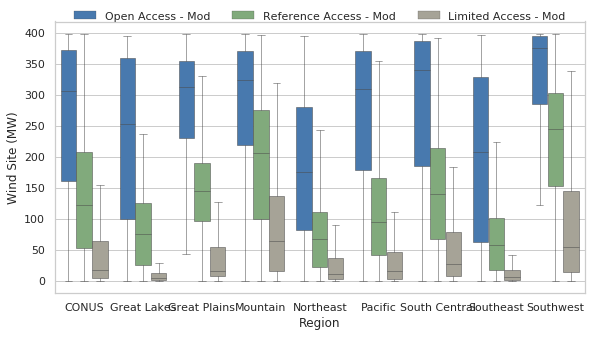

In [172]:
colors = ['windows blue', 'faded green', 'greyish', 'dusty purple']
sns.set_palette(sns.xkcd_palette(colors))

fig, ax = plt.subplots(figsize=(9.5, 5))

t = df[df.scenario.isin(core)]

a = t[t.scenario==core[0]]
a['nrel_region'] = 'CONUS'

b = t[t.scenario==core[1]]
b['nrel_region'] = 'CONUS'

c = t[t.scenario==core[2]]
c['nrel_region'] = 'CONUS'

t = pd.concat([t, a, b, c])

t['order'] = 5
t.loc[t.scenario=='Open Access - Mod', 'order'] = 1
t.loc[t.scenario=='Reference Access - Mod', 'order'] = 2
t.loc[t.scenario=='Limited Access - Mod', 'order'] = 3

t = t.sort_values(by=['order', 'nrel_region'])

g = sns.boxplot(x='nrel_region', y='capacity', hue='scenario', data=t, linewidth=0.5, fliersize=0)

handles, labels = g.get_legend_handles_labels()
g.legend(loc='center', bbox_to_anchor=(0.5, 1.02), frameon=False, ncol=4)

_= ax.set(ylabel='Wind Site (MW)')
_= ax.set(xlabel='Region')

fig.savefig('paper/figure_4.svg')

### all-in LCOE

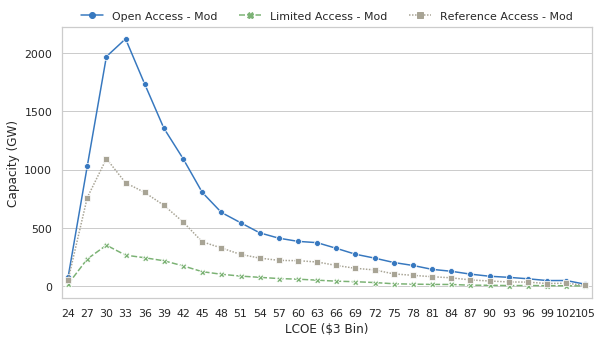

In [204]:
colors = ['windows blue', 'faded green', 'greyish', 'dusty purple']
sns.set_palette(sns.xkcd_palette(colors))
fig, ax = plt.subplots(figsize=(9.5, 5))

df['all_lcoe_bin'] = df.total_lcoe.apply(lambda x: custom_round(x, base=3))

t = df[df.scenario.isin(core)]

t['order'] = 5
t.loc[t.scenario=='Open Access - Mod', 'order'] = 1
t.loc[t.scenario=='Reference - Mod', 'order'] = 2
t.loc[t.scenario=='Limited Access - Mod', 'order'] = 3

t = t.sort_values(by=['order', 'lbnl_region'])

g = sns.lineplot(x='all_lcoe_bin', y='gw', hue='scenario', style='scenario', markers=True,
             data=t[t.total_lcoe<=105], estimator=sum, ci=None)

handles, labels = g.get_legend_handles_labels()
#g.legend(loc='center', bbox_to_anchor=(0.5, 1.04), frameon=False, ncol=3, handles=handles[1:], labels=labels[1:])
g.legend(loc='center', bbox_to_anchor=(0.5, 1.04), frameon=False, ncol=4, handles=handles[1:], labels=labels[1:])

_= ax.set(ylabel='Capacity (GW)')
_= ax.set(xlabel='LCOE ($3 Bin)')
_= ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
_= ax.xaxis.grid(False)
_= ax.set(xlim=(23, 106))

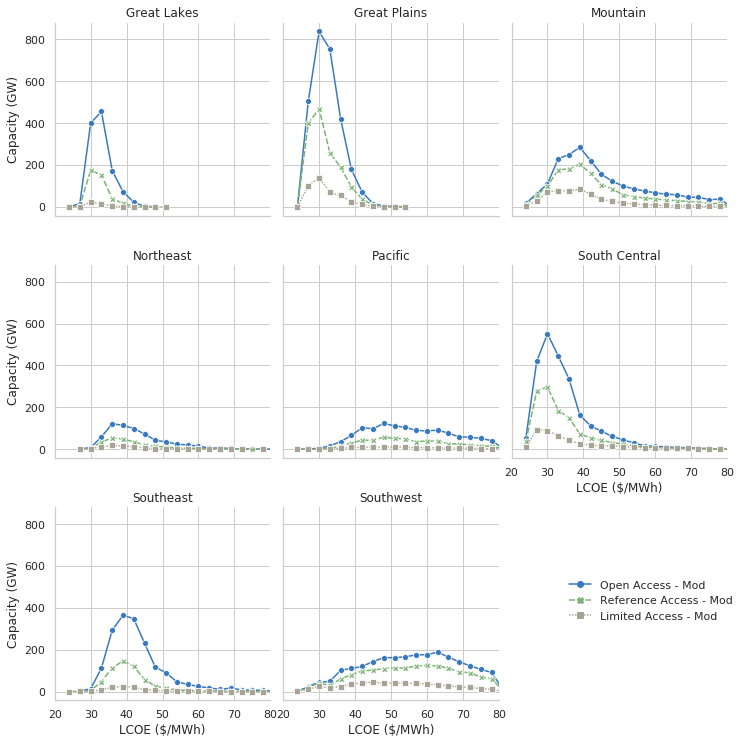

In [203]:
colors = ['windows blue', 'faded green', 'greyish', 'dusty purple']
sns.set_palette(sns.xkcd_palette(colors))
#sns.set_context('talk')

t = df[df.scenario.isin(core)]
t['order'] = 5
t.loc[t.scenario=='Open Access - Mod', 'order'] = 1
t.loc[t.scenario=='Reference Access - Mod', 'order'] = 2
t.loc[t.scenario=='Limited Access - Mod', 'order'] = 3
t = t.sort_values(by=['order', 'nrel_region'])
g = sns.relplot(x='all_lcoe_bin', y='gw', hue='scenario', col='nrel_region', estimator=sum, ci=None,
                 style='scenario', markers=True, data=t[t.total_lcoe<=80], 
                kind='line', col_wrap=3, height=3.5)

leg = g._legend
leg.set_bbox_to_anchor([0.80, 0.2])
g._legend.texts[0].set_text("")

g.set_titles(template='{col_name}')

_= g.set(ylabel='Capacity (GW)')
_= g.set(xlabel='LCOE ($/MWh)')
_= g.set(xlim=(20,80))

g.savefig('paper/siting_lcoe.jpg')

### Supply Curve graph

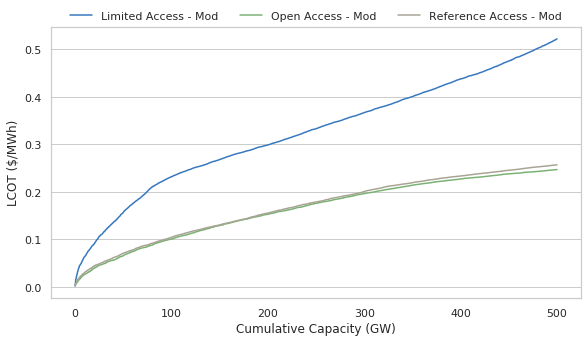

In [453]:
colors = ['windows blue', 'faded green', 'greyish', 'dusty purple']
sns.set_palette(sns.xkcd_palette(colors))

fig, ax = plt.subplots(figsize=(9.5, 5))
t = df#df[df.scenario.isin(friction)]
t = t[t.cum_cap_lcot_gw<=500]

g = sns.lineplot(data=t, x='cum_cap_lcot_gw', y='lcot', hue='scenario')

handles, labels = g.get_legend_handles_labels()
g.legend(loc='center', bbox_to_anchor=(0.5, 1.04), frameon=False, ncol=4, handles=handles[1:], labels=labels[1:])

_= ax.set(xlabel='Cumulative Capacity (GW)')
_= ax.set(ylabel='LCOT ($/MWh)')
#_= ax.set(ylim=(23, 31))
_= ax.xaxis.grid(False)

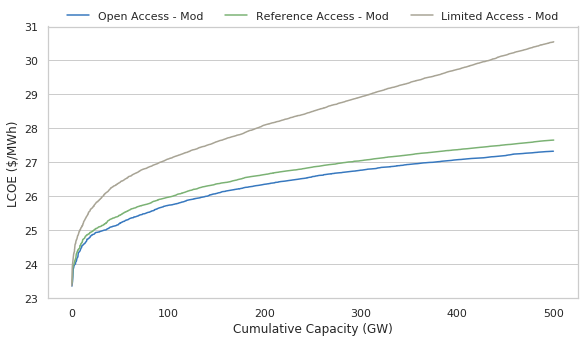

In [454]:
colors = ['windows blue', 'faded green', 'greyish', 'dusty purple']
sns.set_palette(sns.xkcd_palette(colors))

fig, ax = plt.subplots(figsize=(9.5, 5))
t = df#df[df.scenario.isin(friction)]
t = t[t.cum_cap_gw<=500]
t['order'] = 5
t.loc[t.scenario=='Open Access - Mod', 'order'] = 1
t.loc[t.scenario=='Reference Access - Mod', 'order'] = 2
t.loc[t.scenario=='Limited Access - Mod', 'order'] = 3
t = t.sort_values(by=['order', 'nrel_region'])


g = sns.lineplot(data=t, x='cum_cap_gw', y='total_lcoe', hue='scenario')

#s = df[df.scenario.isin(core)]
#s = s[s.cum_cap_site_gw<=500]
#sns.lineplot(data=s, x='cum_cap_site_gw', y='mean_lcoe', 
#             hue='scenario', style='scenario', dashes=[(2, 2), (2, 2), (2, 2)],
#             legend=False)

handles, labels = g.get_legend_handles_labels()
g.legend(loc='center', bbox_to_anchor=(0.5, 1.04), frameon=False, ncol=4, handles=handles[1:], labels=labels[1:])

_= ax.set(xlabel='Cumulative Capacity (GW)')
_= ax.set(ylabel='LCOE ($/MWh)')
_= ax.set(ylim=(23, 31))
_= ax.xaxis.grid(False)

# Wind Technology

### Capacity & Generation

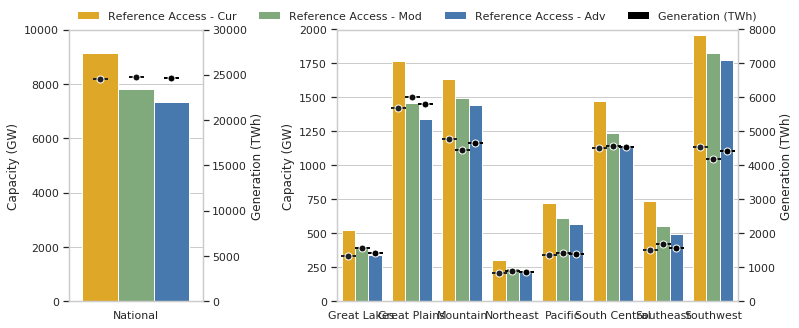

In [193]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 3]})
#plt.figure(figsize=(9.5,5))

colors = ['amber', 'faded green', 'windows blue']
sns.set_palette(sns.xkcd_palette(colors))

t = df[(df.scenario.isin(base) & (df.setting=='Land-Based'))]
t['order'] = 1
t.loc[t.scenario=='Reference Access - Cur', 'order'] = 1
t.loc[t.scenario=='Reference Access - Mod', 'order'] = 2
t.loc[t.scenario=='Reference Access - Adv', 'order'] = 3
t['twh'] = t.mwh / 1000 / 1000
t = t.sort_values(by=['order', 'nrel_region'])
t['national'] = 'National'

# National 
gen0 = pd.DataFrame(t.groupby(['scenario', 'national'])['twh'].sum()).reset_index()
g0 = sns.barplot(x='national', y='gw', hue='scenario', data=t, estimator=sum, ci=None, ax=ax[0])
ax0 = ax[0].twinx()
s0 = sns.stripplot(x='national', y='twh', hue='scenario', data=gen0, ax=ax0, jitter=0,
        split=True, color='black', linewidth=2, edgecolor='black', size=15, marker='_')
s1 = sns.stripplot(x='national', y='twh', hue='scenario', data=gen0, ax=ax0, jitter=0,
        split=True, color='black', linewidth=1, edgecolor='white', size=7)

# Regional
gen = pd.DataFrame(t.groupby(['scenario', 'nrel_region'])['twh'].sum()).reset_index()
gen['order'] = np.arange(len(gen))
g = sns.barplot(x='nrel_region', y='gw', hue='scenario', data=t, estimator=sum, ci=None, ax=ax[1])
ax2 = ax[1].twinx()
s = sns.stripplot(x='nrel_region', y='twh', hue='scenario', data=gen, ax=ax2, jitter=0,
        split=True, color='black', linewidth=2, edgecolor='black', size=15, marker='_')
s2 = sns.stripplot(x='nrel_region', y='twh', hue='scenario', data=gen, ax=ax2, jitter=0,
        split=True, color='black', linewidth=1, edgecolor='white', size=7)

# Legend
handles, labels = g.get_legend_handles_labels()
patch = mpatches.Patch(label='Generation (TWh)', facecolor='black', capstyle='round', joinstyle='round')
handles.append(patch)
labels.append('Generation (TWh)')

plt.subplots_adjust(wspace = 0.5)

# Labels
_= ax2.xaxis.grid(False)
_= ax2.yaxis.grid(False)
_= ax2.set(ylabel='Generation (TWh)')
_= ax2.get_legend().remove()
_= ax2.set(ylim=(0, 8000))

_= ax0.xaxis.grid(False)
_= ax0.yaxis.grid(False)
_= ax0.set(ylabel='Generation (TWh)')
_= ax0.get_legend().remove()
_= ax0.set(ylim=(0, 30000))

_= g.set(xlabel=None)
_= g.set(ylabel='Capacity (GW)')
_= g.set(ylim=(0,2000))
_= g.get_legend().remove()

_= g0.set(xlabel=None)
_= g0.set(ylabel='Capacity (GW)')
_= g0.set(ylim=(0,10000))
_= g0.get_legend().remove()

# plot the legend
_= plt.legend(loc='center', bbox_to_anchor=(0.2, 1.05), frameon=False, ncol=4, 
              handles=handles, labels=labels)

plt.savefig('paper/figure_8.svg')

In [ ]:
t = df[(df.scenario.isin(base) & (df.setting=='Land-Based'))]
t['order'] = 1
t.loc[t.scenario=='Reference Access - Cur', 'order'] = 1
t.loc[t.scenario=='Reference Access - Mod', 'order'] = 2
t.loc[t.scenario=='Reference Access - Adv', 'order'] = 3
t['twh'] = t.mwh / 1000 / 1000
t = t.sort_values(by=['order', 'nrel_region'])
t['national'] = 'National'

# National 
gen0 = pd.DataFrame(t.groupby(['scenario', 'national'])['twh'].sum()).reset_index()
g0 = sns.barplot(x='national', y='gw', hue='scenario', data=t, estimator=sum, ci=None, ax=ax[0])
ax0 = ax[0].twinx()
s0 = sns.stripplot(x='national', y='twh', hue='scenario', data=gen0, ax=ax0, jitter=0,
        split=True, color='black', linewidth=2, edgecolor='black', size=15, marker='_')

# Capacity Factor

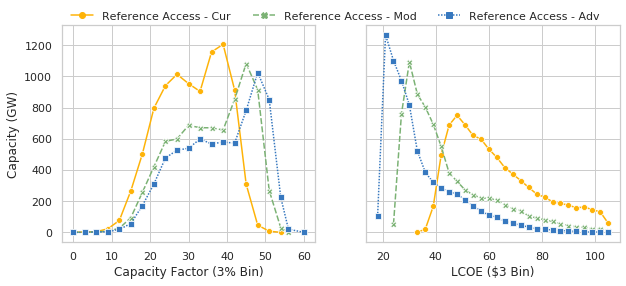

In [525]:
colors = ['amber', 'faded green', 'windows blue']
sns.set_palette(sns.xkcd_palette(colors))
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

t = df[(df.scenario.isin(base) & (df.setting=='Land-Based'))]
t['order'] = 1
t.loc[t.scenario=='Reference Access - Cur', 'order'] = 1
t.loc[t.scenario=='Reference Access - Mod', 'order'] = 2
t.loc[t.scenario=='Reference Access - Adv', 'order'] = 3
t = t.sort_values(by=['order', 'nrel_region'])
t['cf_int'] = (t.cf_bin * 100).astype(np.int)



df['all_lcoe_bin'] = df.total_lcoe.apply(lambda x: custom_round(x, base=3))
t2 = df[df.scenario.isin(base)]
t2['order'] = 1
t2.loc[t2.scenario=='Reference Access - Cur', 'order'] = 1
t2.loc[t2.scenario=='Reference Access - Mod', 'order'] = 2
t2.loc[t2.scenario=='Reference Access - Adv', 'order'] = 3
t2 = t2.sort_values(by=['order', 'nrel_region'])


g = sns.lineplot(x='cf_int', y='gw', hue='scenario', style='scenario', markers=True,
             data=t, estimator=sum, ci=None, ax=ax[0])

g2 = sns.lineplot(x='all_lcoe_bin', y='gw', hue='scenario', style='scenario', markers=True,
             data=t2[t2.total_lcoe<=105], estimator=sum, ci=None, ax=ax[1], legend=False)

handles, labels = g.get_legend_handles_labels()
g.legend(loc='center', bbox_to_anchor=(1.08, 1.04), frameon=False, ncol=3, handles=handles[1:], labels=labels[1:])

_= ax[0].set(ylabel='Capacity (GW)')
_= ax[0].set(xlabel='Capacity Factor (3% Bin)')

#_= ax[1].set(ylabel='Capacity (GW)')
_= ax[1].set(xlabel='LCOE ($3 Bin)')
#_= ax[0].xaxis.set_major_locator(ticker.MultipleLocator(3))
#_= ax[0].xaxis.grid(False)
#_= ax[0].set(xlim=(2, 61))

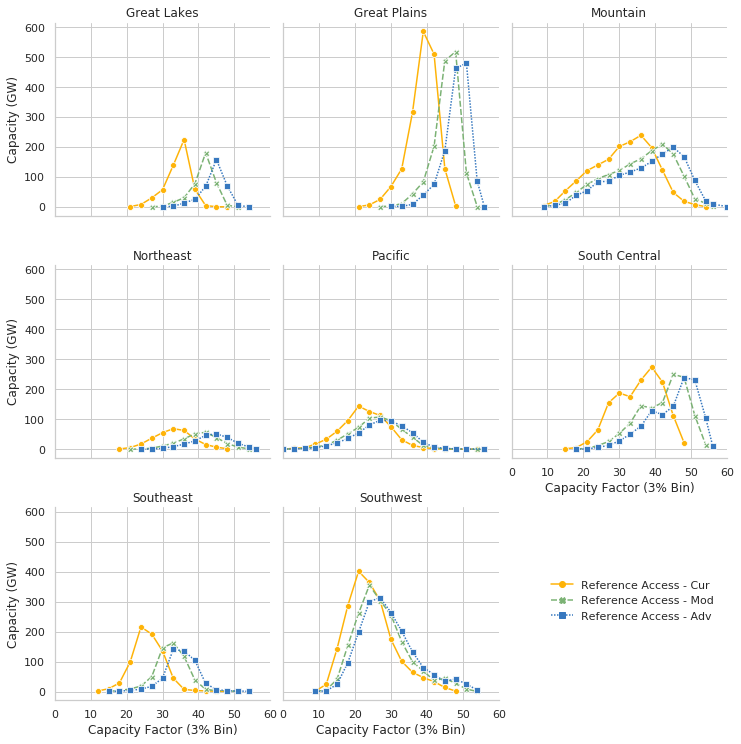

In [467]:
colors = ['amber', 'faded green', 'windows blue']
sns.set_palette(sns.xkcd_palette(colors))

t = df[(df.scenario.isin(base) & (df.setting=='Land-Based'))]

t['cf_int'] = (t.cf_bin * 100).astype(np.int)

t['order'] = 1
t.loc[t.scenario=='Reference Access - Cur', 'order'] = 1
t.loc[t.scenario=='Reference Access - Mod', 'order'] = 2
t.loc[t.scenario=='Reference Access - Adv', 'order'] = 3
t = t.sort_values(by=['order', 'nrel_region'])
g = sns.relplot(x='cf_int', y='gw', hue='scenario', col='nrel_region', estimator=sum, ci=None,
                 style='scenario', markers=True, data=t, 
                kind='line', col_wrap=3, height=3.5)

leg = g._legend
leg.set_bbox_to_anchor([0.78, 0.2])
g._legend.texts[0].set_text("")

g.set_titles(template='{col_name}')

_= g.set(ylabel='Capacity (GW)')
_= g.set(xlabel='Capacity Factor (3% Bin)')
_= g.set(xlim=(0,60))

g.savefig('paper/technology_capacity_factor.jpg')

# LCOT

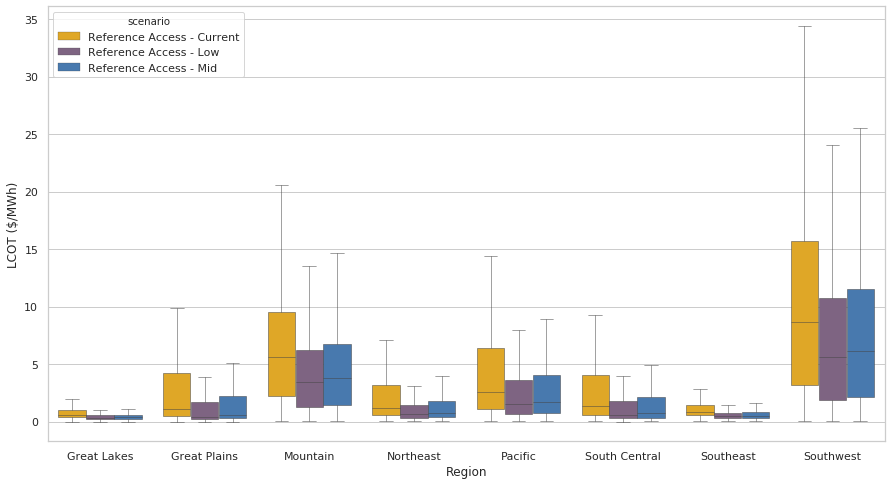

In [58]:
colors = ['amber', 'dusty purple', 'windows blue']
sns.set_palette(sns.xkcd_palette(colors))
fig, ax = plt.subplots(figsize=(15, 8))

t = df[df.scenario.isin(base)]
t = t.sort_values(by=['scenario', 'nrel_region'])
g = sns.boxplot(x='nrel_region', y='lcot', hue='scenario', data=t[t.total_lcoe>0], showfliers=False,
               linewidth=0.5)

_= ax.set(ylabel='LCOT ($/MWh)')
_= ax.set(xlabel='Region')

# LCOE 

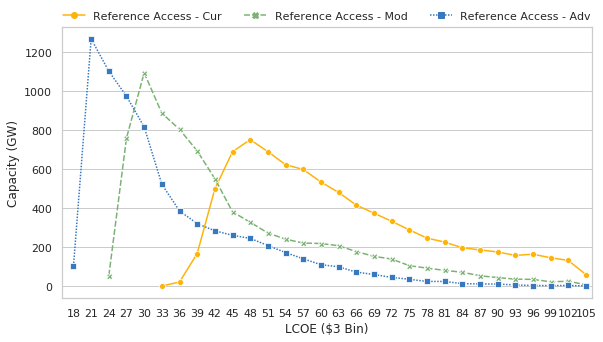

In [23]:
fig, ax = plt.subplots(figsize=(9.5, 5))
colors = ['amber', 'faded green', 'windows blue']
sns.set_palette(sns.xkcd_palette(colors))

df['all_lcoe_bin'] = df.total_lcoe.apply(lambda x: custom_round(x, base=3))

t = df[df.scenario.isin(base)]

t['order'] = 1
t.loc[t.scenario=='Reference Access - Cur', 'order'] = 1
t.loc[t.scenario=='Reference Access - Mod', 'order'] = 2
t.loc[t.scenario=='Reference Access - Adv', 'order'] = 3
t = t.sort_values(by=['order', 'nrel_region'])

g = sns.lineplot(x='all_lcoe_bin', y='gw', hue='scenario', style='scenario', markers=True,
             data=t[t.total_lcoe<=105], estimator=sum, ci=None)

handles, labels = g.get_legend_handles_labels()
g.legend(loc='center', bbox_to_anchor=(0.5, 1.04), frameon=False, ncol=3, handles=handles[1:], labels=labels[1:])

_= ax.set(ylabel='Capacity (GW)')
_= ax.set(xlabel='LCOE ($3 Bin)')
_= ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
_= ax.xaxis.grid(False)
_= ax.set(xlim=(16, 106))

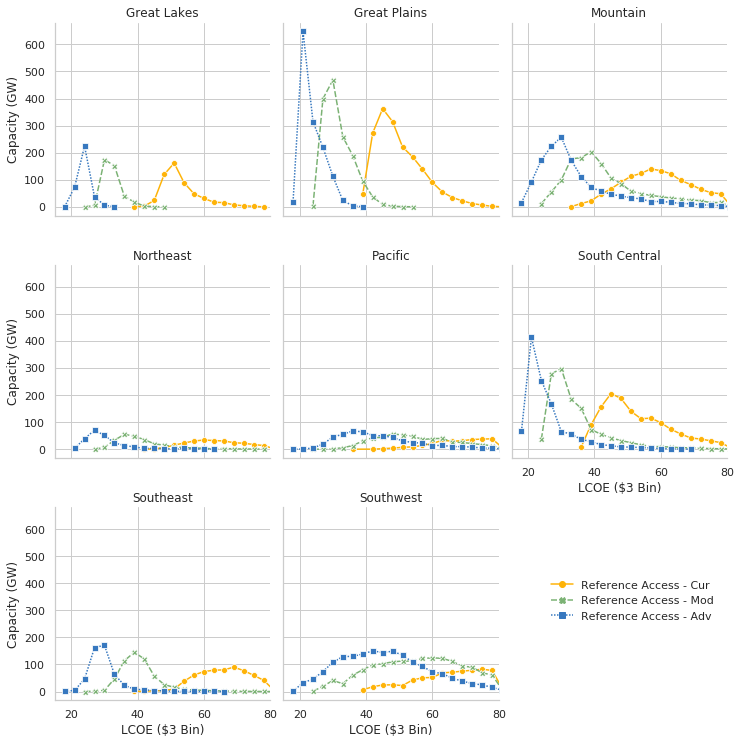

In [25]:
colors = ['amber', 'faded green', 'windows blue']
sns.set_palette(sns.xkcd_palette(colors))

t = df[(df.scenario.isin(base) & (df.setting=='Land-Based'))]

t['order'] = 1
t.loc[t.scenario=='Reference Access - Cur', 'order'] = 1
t.loc[t.scenario=='Reference Access - Mod', 'order'] = 2
t.loc[t.scenario=='Reference Access - Adv', 'order'] = 3
t = t.sort_values(by=['order', 'nrel_region'])
g = sns.relplot(x='all_lcoe_bin', y='gw', hue='scenario', col='nrel_region', estimator=sum, ci=None,
                 style='scenario', markers=True, data=t[t.total_lcoe<=80], 
                kind='line', col_wrap=3, height=3.5)

leg = g._legend
leg.set_bbox_to_anchor([0.78, 0.2])
g._legend.texts[0].set_text("")

g.set_titles(template='{col_name}')

_= g.set(ylabel='Capacity (GW)')
_= g.set(xlabel='LCOE ($3 Bin)')
_= g.set(xlim=(15, 80))

g.savefig('paper/technology_lcoe.jpg')

### Supply curve graph

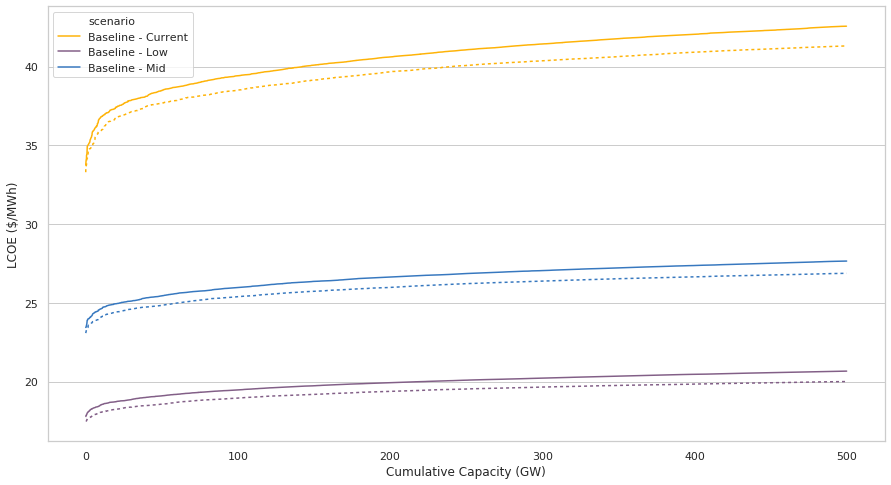

In [17]:
colors = ['amber', 'dusty purple', 'windows blue']
sns.set_palette(sns.xkcd_palette(colors))

i= 500
fig, ax = plt.subplots(figsize=(15, 8))
t = df[df.scenario.isin(base)]
t = t[t.cum_cap_gw<=i]
t = t.sort_values(by=['scenario', 'lbnl_region'])

s = df[df.scenario.isin(base)]
s = s[s.cum_cap_site_gw<=i]
s = s.sort_values(by=['scenario', 'lbnl_region'])

sns.lineplot(data=t, x='cum_cap_gw', y='total_lcoe', hue='scenario')
sns.lineplot(data=s, x='cum_cap_site_gw', y='mean_lcoe', 
             hue='scenario', style='scenario', dashes=[(2, 2), (2, 2), (2, 2)],
             legend=False)

_= ax.set(xlabel='Cumulative Capacity (GW)')
_= ax.set(ylabel='LCOE ($/MWh)')
#_= ax.set(ylim=(23, 31))
_= ax.xaxis.grid(False)

# Sensitivities

### Capacity

In [99]:
c = ['Open Access - Mid', 'Fed Land Exclusion - Mid', 'Mid Setbacks - Mid', 
     'High Setbacks - Mid', 'Radar Limits - Mid', 'Existing Setbacks - Mid']
df[df.scenario.isin(c)].groupby('scenario').agg({'gw': np.sum}).reset_index()

,scenario,gw
0,Existing Setbacks - Mid,"14,514.96"
1,Fed Land Exclusion - Mid,"12,026.77"
2,High Setbacks - Mid,"4,181.59"
3,Mid Setbacks - Mid,"8,634.74"
4,Open Access - Mid,"15,175.15"
5,Radar Limits - Mid,"13,449.78"


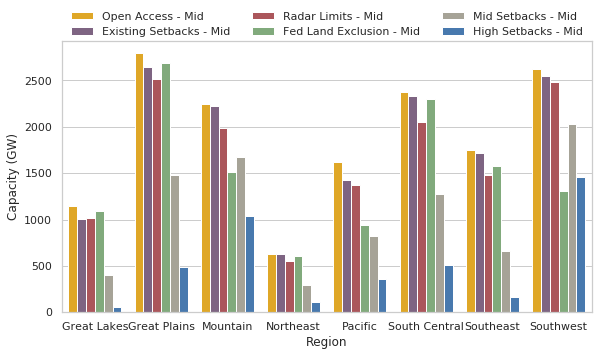

In [97]:
c = ['Open Access - Mid', 'Fed Land Exclusion - Mid', 'Mid Setbacks - Mid', 
     'High Setbacks - Mid', 'Radar Limits - Mid', 'Existing Setbacks - Mid']

fig, ax = plt.subplots(figsize=(9.5, 5))
colors = ['amber', 'dusty purple', 'dusty red', 'faded green', 'greyish', 'windows blue', 'olive']
sns.set_palette(sns.xkcd_palette(colors))

t = df[(df.scenario.isin(c) & (df.setting=='Land-Based'))]

t['order'] = 1
t.loc[t.scenario=='Open Access - Mid', 'order'] = 1
t.loc[t.scenario=='Existing Setbacks - Mid', 'order'] = 2
t.loc[t.scenario=='Radar Limits - Mid', 'order'] = 3
t.loc[t.scenario=='Fed Land Exclusion - Mid', 'order'] = 4
t.loc[t.scenario=='Mid Setbacks - Mid', 'order'] = 5
t.loc[t.scenario=='High Setbacks - Mid', 'order'] = 6

t = t.sort_values(by=['order', 'nrel_region'])

g = sns.barplot(x='nrel_region', y='gw', hue='scenario', data=t, estimator=sum, ci=None)

g.legend(loc='center', bbox_to_anchor=(0.5, 1.06), ncol=3, frameon=False)
_= g.set(xlabel='Region')
_= g.set(ylabel='Capacity (GW)')

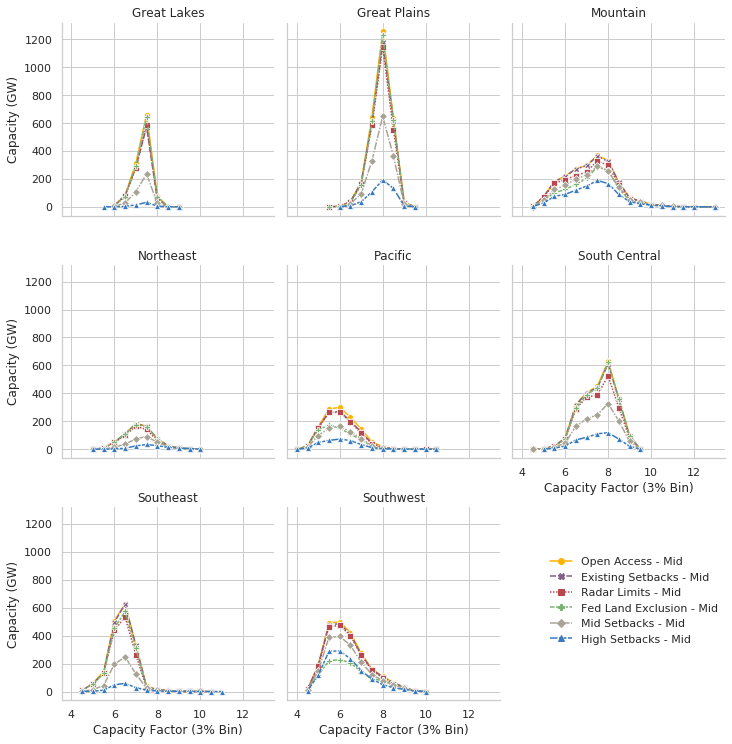

In [80]:
c = ['Open Access - Mid', 'Fed Land Exclusion - Mid', 'Mid Setbacks - Mid', 
     'High Setbacks - Mid', 'Radar Limits - Mid', 'Existing Setbacks - Mid']

colors = ['amber', 'dusty purple', 'dusty red', 'faded green', 'greyish', 'windows blue', 'olive']
sns.set_palette(sns.xkcd_palette(colors))

t = df[(df.scenario.isin(c) & (df.setting=='Land-Based'))]

t['order'] = 1
t.loc[t.scenario=='Open Access - Mid', 'order'] = 1
t.loc[t.scenario=='Existing Setbacks - Mid', 'order'] = 2
t.loc[t.scenario=='Radar Limits - Mid', 'order'] = 3
t.loc[t.scenario=='Fed Land Exclusion - Mid', 'order'] = 4
t.loc[t.scenario=='Mid Setbacks - Mid', 'order'] = 5
t.loc[t.scenario=='High Setbacks - Mid', 'order'] = 6
t = t.sort_values(by=['order', 'nrel_region'])

g = sns.relplot(x='ws_bin', y='gw', hue='scenario', col='nrel_region', estimator=sum, ci=None,
                 style='scenario', markers=True, data=t[t.total_lcoe<=80], 
                kind='line', col_wrap=3, height=3.5)

leg = g._legend
leg.set_bbox_to_anchor([0.78, 0.2])
g._legend.texts[0].set_text("")

g.set_titles(template='{col_name}')

_= g.set(ylabel='Capacity (GW)')
_= g.set(xlabel='Capacity Factor (3% Bin)')
#_= g.set(xlim=(15, 80))

#g.savefig('core_ws.svg')

## Wind Speed Curves

In [224]:
turbines = pd.read_csv('/scratch/alopez/deployment_scenarios/csv/turbinepowercurves.csv')

In [225]:
a = turbines[['ws', 'current']]
a['scenario'] = 'Current'
a.rename(columns={'current': 'power'}, inplace=True)

b = turbines[['ws', 'mid']]
b['scenario'] = 'Mid'
b.rename(columns={'mid': 'power'}, inplace=True)

c = turbines[['ws', 'low']]
c['scenario'] = 'Low'
c.rename(columns={'low': 'power'}, inplace=True)

t = pd.concat([a, b, c])

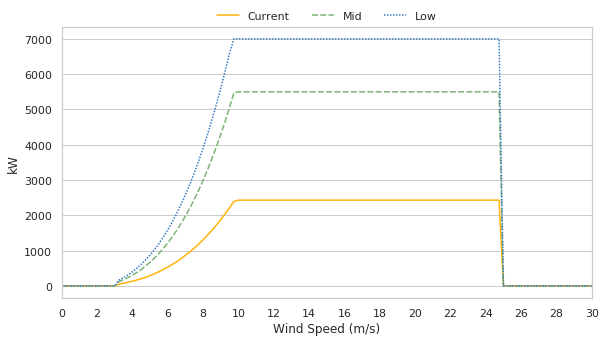

In [239]:
fig, ax = plt.subplots(figsize=(9.5, 5))

g = sns.lineplot(x='ws', y='power', hue='scenario', style='scenario', markers=False, data=t)

handles, labels = g.get_legend_handles_labels()
_= g.legend(loc='center', bbox_to_anchor=(0.5, 1.04), frameon=False, ncol=3, handles=handles[1:], labels=labels[1:])

_= ax.set(ylabel='kW')
_= ax.set(xlabel='Wind Speed (m/s)')
_= ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
_= ax.xaxis.grid(False)
_= ax.set(xlim=(0,30))

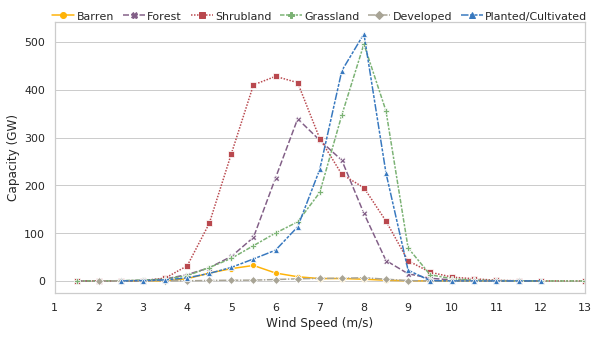

In [354]:
# land cover 
n = [11, 12, 21, 22, 23, 24, 31, 41, 42, 43, 51, 52, 71, 72, 73, 74, 81, 82, 90, 95]
r = ['Water', 'Perennial Snow', 'Developed', 'Developed', 'Developed', 'Developed',
     'Barren', 'Forest', 'Forest', 'Forest', 'Shrubland', 'Shrubland', 'Grassland', 'Grassland', 'Grassland',
     'Grassland', 'Planted/Cultivated', 'Planted/Cultivated', 'Wetlands', 'Wetlands']
f = pd.DataFrame({'land_cover': n, 'land_cover_name': r})

# extract single scenario
t = df[df.scenario=='Reference Access - Mid']
# convert to json
t['usa_mrlc_nlcd2011'] = t.usa_mrlc_nlcd2011.apply(lambda x: {'0': 0} if pd.isna(x) else json.loads(x))
# normalize into a table
n = pd.json_normalize(t.usa_mrlc_nlcd2011)
# convert to MW
n = n[:] * (90*90) / 1000000 * 3 / 1000
# add sc_gid to data for joining
n['sc_gid'] = t.sc_gid.values
# unpivot the data
n = n.melt(id_vars='sc_gid')
n.rename(columns={'variable':'land_cover', 'value': 'gw'}, inplace=True)
# remove nan
n = n[~n.gw.isna()]
# convert object 
n['land_cover'] = pd.to_numeric(n.land_cover)
# join names
n = n.merge(f, on='land_cover')
# join other data
n = n.merge(t[['sc_gid', 'ws_bin', 'cf_bin', 'all_lcoe_bin']], on='sc_gid')

fig, ax = plt.subplots(figsize=(9.5, 5))
colors = ['amber', 'dusty purple', 'dusty red', 'faded green', 'greyish', 'windows blue', 'olive']
sns.set_palette(sns.xkcd_palette(colors))

n = n[~n.land_cover_name.isin(['Water', 'Wetlands', 'Perennial Snow'])]

g = sns.lineplot(x='ws_bin', y='gw', markers=True, hue='land_cover_name', style='land_cover_name',
             data=n, estimator=sum, ci=None)

handles, labels = g.get_legend_handles_labels()
_= g.legend(loc='center', bbox_to_anchor=(0.5, 1.02), frameon=False, ncol=6, 
            handles=handles[1:], labels=labels[1:], columnspacing=0.8, handletextpad=0.2)

_= ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
_= ax.set(ylabel='Capacity (GW)')
_= ax.set(xlabel='Wind Speed (m/s)')
_= ax.set(xlim=(1, 13))
_= ax.xaxis.grid(False)

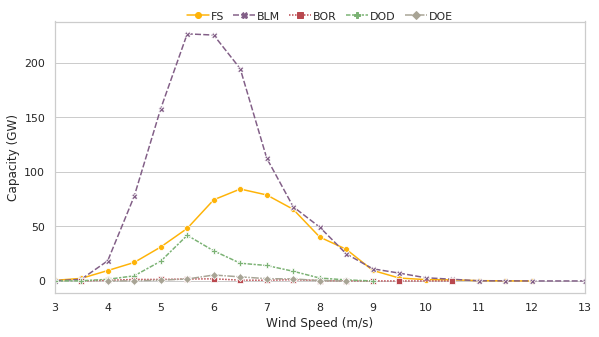

In [369]:
# Federal land lookup
r = ['DOD','FS','FWS','NPS','VA','BLM','BOR','NASA','BIA','DOE','DOT','GSA','USDA','DOJ','HHS','TVA','DOL','MWAA','DOC']
n = np.arange(1, len(r)+1)
f = pd.DataFrame({'fed_land_owner': n, 'fed_land_name': r})

# extract single scenario
t = df[df.scenario=='Reference Access - Mid']
# convert to json
t['fed_land_owner'] = t.fed_land_owner.apply(lambda x: {'0': 0} if pd.isna(x) else json.loads(x))
# normalize into a table
n = pd.json_normalize(t.fed_land_owner)
# convert to MW
n = n[:] * (90*90) / 1000000 * 3 / 1000
# add sc_gid to data for joining
n['sc_gid'] = t.sc_gid.values
# unpivot the data
n = n.melt(id_vars='sc_gid')
n.rename(columns={'variable':'fed_land_owner', 'value': 'gw'}, inplace=True)
# remove nan
n = n[~n.gw.isna()]
# convert object 
n['fed_land_owner'] = pd.to_numeric(n.fed_land_owner)
# join names
n = n.merge(f, on='fed_land_owner')
# join other data
n = n.merge(t[['sc_gid', 'ws_bin', 'cf_bin', 'all_lcoe_bin']], on='sc_gid')

fig, ax = plt.subplots(figsize=(9.5, 5))
colors = ['amber', 'dusty purple', 'dusty red', 'faded green', 'greyish', 'windows blue', 'olive']
sns.set_palette(sns.xkcd_palette(colors))

n = n[n.fed_land_name.isin(['BLM', 'FS', 'DOD', 'DOE', 'BOR'])]

g = sns.lineplot(x='ws_bin', y='gw', markers=True, hue='fed_land_name', style='fed_land_name',
             data=n, estimator=sum, ci=None)

handles, labels = g.get_legend_handles_labels()
_= g.legend(loc='center', bbox_to_anchor=(0.5, 1.02), frameon=False, ncol=6, 
            handles=handles[1:], labels=labels[1:], columnspacing=0.8, handletextpad=0.2)

_= ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
_= ax.set(ylabel='Capacity (GW)')
_= ax.set(xlabel='Wind Speed (m/s)')
_= ax.set(xlim=(3, 13))
_= ax.xaxis.grid(False)

In [365]:
n.fe

,sc_gid,fed_land_owner,gw,fed_land_name,ws_bin,cf_bin,all_lcoe_bin


### Heatgraphs

In [242]:
cols = ['Open Access - Current', 'Open Access - Low', 'Legacy - Current',
 'Baseline - Current', 'Baseline - Mid', 'Baseline - Low', 'Limited Access - Mid',
 'Existing Social Acceptance - Mid', 'Mid Social Acceptance - Mid', 'Mid Social Acceptance - Low',
 'Low Social Acceptance - Mid', 'Mid Social Acceptance - Low',
 'Radar Limits - Mid', 'Fed Land Exclusion - Mid', 
 'Smart Bat Curtailment - Mid', 'Blanket Bat Curtailment - Mid']

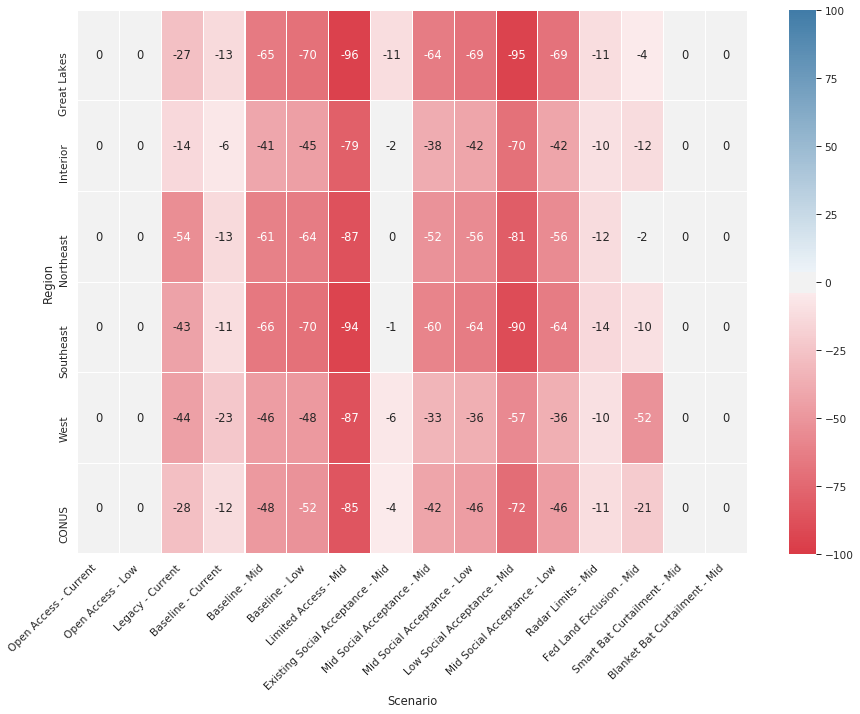

In [245]:
# GW Capacity Difference OA - Scenario
cmap = sns.diverging_palette(10, 240, n=9, as_cmap=True)
s = df[df.setting=='Land-Based']
s = s.groupby(['lbnl_region', 'scenario']).agg({'capacity': np.sum}).reset_index()
oa = s[s.scenario=='Open Access - Mid']
s = s[s.scenario!='Open Access - Mid']
s = s.merge(oa, on='lbnl_region')
s['gw_reduction'] = (s.capacity_x - s.capacity_y) / s.capacity_y * 100 #(df.A2 - df.A1)/df.A1 * 100
s = s.drop(labels=['scenario_y', 'capacity_y'], axis=1)
s = s.rename(columns={'scenario_x': 'scenario', 'capacity_x': 'capacity'})
s = s.pivot(index='lbnl_region', columns='scenario', values='gw_reduction')
s[s.isna()] = 0
s = s.astype(np.int)
# CONUS
t = df[df.setting=='Land-Based']
t = t.groupby(['scenario']).agg({'capacity': np.sum}).reset_index()
oa = t[t.scenario=='Open Access - Mid']
t = t[t.scenario!='Open Access - Mid']
t['cap_oa'] = oa.capacity.values[0]
t['pct'] = (t.capacity - t.cap_oa) / t.cap_oa * 100
t = t['pct'].values.astype(np.int)
a = pd.DataFrame(columns=s.columns, data=[t], index=['CONUS'])
s = pd.concat([s, a])

fig, ax = plt.subplots(figsize=(15, 10))
g = sns.heatmap(s[cols], square=False, linewidths=0.1, cmap=cmap, vmax=100, vmin=-100, center=0, annot=True
                )#cbar_kws={'label': 'Capacity % Change from OA - mid'})
_= g.set(xlabel='Scenario')
_= g.set(ylabel='Region')
_= g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

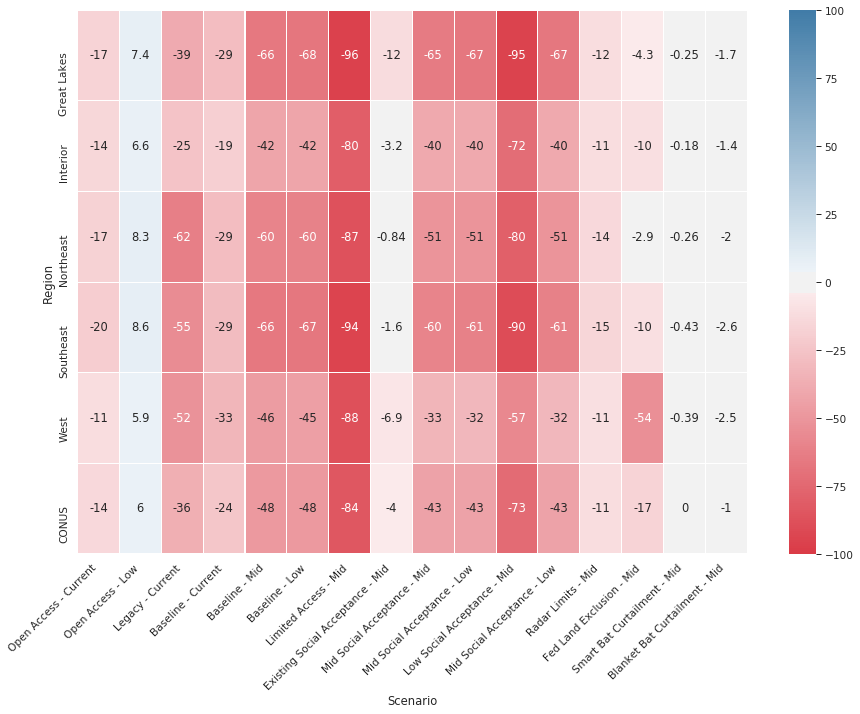

In [249]:
# GWh Capacity Difference OA - Scenario
cmap = sns.diverging_palette(10, 240, n=9, as_cmap=True)
s = df[df.setting=='Land-Based']
s = s.groupby(['lbnl_region', 'scenario']).agg({'mwh': np.sum}).reset_index()
oa = s[s.scenario=='Open Access - Mid']
s = s[s.scenario!='Open Access - Mid']
s = s.merge(oa, on='lbnl_region')
s['mwh_reduction'] = (s.mwh_x - s.mwh_y) / s.mwh_y * 100 #(df.A2 - df.A1)/df.A1 * 100
s = s.drop(labels=['scenario_y', 'mwh_y'], axis=1)
s = s.rename(columns={'scenario_x': 'scenario', 'mwh_x': 'capacity'})
s = s.pivot(index='lbnl_region', columns='scenario', values='mwh_reduction')
s[s.isna()] = 0
#s = s.astype(np.int)
# CONUS
t = df[df.setting=='Land-Based']
t = t.groupby(['scenario']).agg({'mwh': np.sum}).reset_index()
oa = t[t.scenario=='Open Access - Mid']
t = t[t.scenario!='Open Access - Mid']
t['cap_oa'] = oa.mwh.values[0]
t['pct'] = (t.mwh - t.cap_oa) / t.cap_oa * 100
t = t['pct'].values.astype(np.int)
a = pd.DataFrame(columns=s.columns, data=[t], index=['CONUS'])
s = pd.concat([s, a])

fig, ax = plt.subplots(figsize=(15, 10))
g = sns.heatmap(s[cols], square=False, linewidths=0.1, cmap=cmap, vmax=100, vmin=-100, center=0, annot=True
                )#cbar_kws={'label': 'Capacity % Change from OA - mid'})
_= g.set(xlabel='Scenario')
_= g.set(ylabel='Region')
_= g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

/home/alopez/anaconda3/envs/gdspy/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/alopez/anaconda3/envs/gdspy/lib/python3.7/site-packages/pandas/core/indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


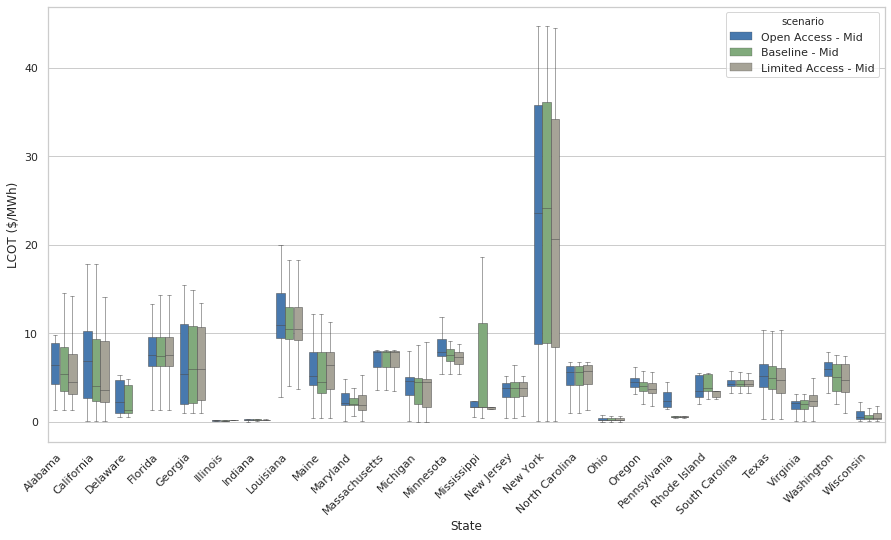

In [377]:
colors = ['windows blue', 'faded green', 'greyish', 'amber', 'dusty purple', 'dusty red', 'light yellow']
sns.set_palette(sns.xkcd_palette(colors))
fig, ax = plt.subplots(figsize=(15, 8))

t = df[((df.setting!='Land-Based') & (df.scenario.isin(core)))]

t['order'] = 1
t.loc[t.scenario=='Open Access - Mid', 'order'] = 1
t.loc[t.scenario=='Baseline - Mid', 'order'] = 2
t.loc[t.scenario=='Limited Access - Mid', 'order'] = 3
t = t.sort_values(by=['order', 'state'])

g = sns.boxplot(x='state', y='lcot', hue='scenario', data=t, showfliers=False, linewidth=0.5)

_= g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
_= ax.set(ylabel='LCOT ($/MWh)')
_= ax.set(xlabel='State')

# Characterizations

In [62]:
# Federal land lookup
r = ['DOD','FS','FWS','NPS','VA','BLM','BOR','NASA','BIA','DOE','DOT','GSA','USDA','DOJ','HHS','TVA','DOL','MWAA','DOC']
n = np.arange(1, len(r)+1)
f = pd.DataFrame({'fed_land_owner': n, 'fed_land_name': r})

# extract single scenario
t = df[df.scenario=='Reference Access - Mid']
# convert to json
t['fed_land_owner'] = t.fed_land_owner.apply(lambda x: {'0': 0} if pd.isna(x) else json.loads(x))
# normalize into a table
fed = pd.json_normalize(t.fed_land_owner)
# convert to GW
fed_sum = pd.DataFrame(fed.sum(axis=0) * (90*90) / 1000000 * 3 / 1000).reset_index()
# rename for easy reading
fed_sum.rename(columns={'index': 'fed_land_owner', 0: 'gw'}, inplace=True)
# convert from object to numberic 
fed_sum['fed_land_owner'] = pd.to_numeric(fed_sum.fed_land_owner)
# join with federal names
fed_sum = fed_sum.merge(f, on='fed_land_owner')
fed_sum = fed_sum.sort_values(by='gw', ascending=False).reset_index()

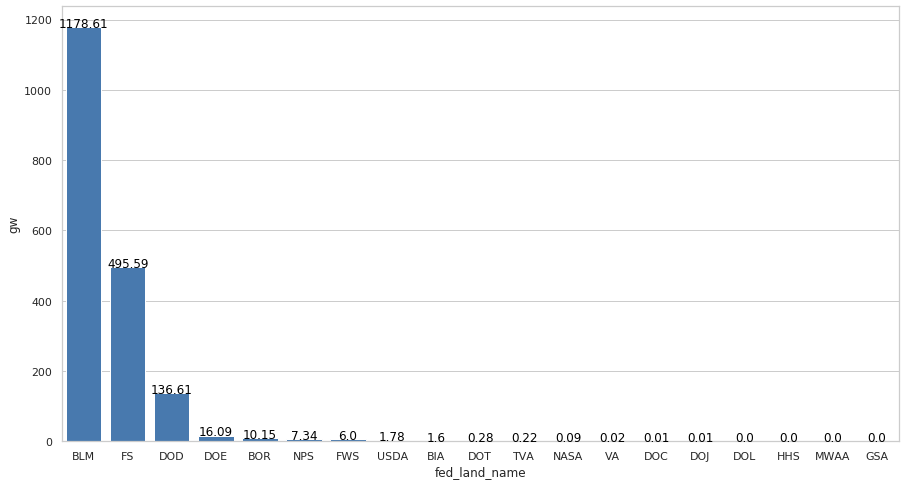

In [63]:
plt.figure(figsize=(15,8))

g = sns.barplot(x='fed_land_name', y='gw', data=fed_sum, color='#3778bf')

for index, row in fed_sum.iterrows():
    g.text(index,row.gw, round(row.gw,2), color='black', ha="center")
    
_= ax.set(ylabel='Capacity (GW)')
_= ax.set(xlabel='Federal Land Owner')

In [395]:
t

,index,land_cover_name,land_cover,gw,scenario
0,9,Shrubland,52.00,"2,593.87",Reference Access - Mod
1,6,Grassland,71.00,"1,862.18",Reference Access - Mod
2,8,Planted/Cultivated,163.00,"1,715.37",Reference Access - Mod
3,5,Forest,126.00,"1,498.56",Reference Access - Mod
4,0,Barren,31.00,120.55,Reference Access - Mod
5,4,Developed Open Space,21.00,30.93,Reference Access - Mod
6,2,Developed Low,22.00,2.70,Reference Access - Mod
7,3,Developed Med,23.00,0.60,Reference Access - Mod
8,1,Developed High,24.00,0.17,Reference Access - Mod
9,7,Perennial Snow,12.00,0.00,Reference Access - Mod


In [394]:
# Federal land lookup
re = []
for scene in ['Reference Access - Mod']:#, 'Open Access - Mid', 'Limited Access - Mid']:
    n = [11, 12, 21, 22, 23, 24, 31, 41, 42, 43, 51, 52, 71, 72, 73, 74, 81, 82, 90, 95]
    r = ['Water', 'Perennial Snow', 'Developed', 'Developed', 'Developed', 'Developed',
         'Barren', 'Forest', 'Forest', 'Forest', 'Shrubland', 'Shrubland', 'Grassland', 'Grassland', 'Grassland',
         'Grassland', 'Planted/Cultivated', 'Planted/Cultivated', 'Wetlands', 'Wetlands']
    
    r = ['Water', 'Perennial Snow', 'Developed Open Space', 'Developed Low', 'Developed Med', 'Developed High',
         'Barren', 'Forest', 'Forest', 'Forest', 'Shrubland', 'Shrubland', 'Grassland', 'Grassland', 'Grassland',
         'Grassland', 'Planted/Cultivated', 'Planted/Cultivated', 'Wetlands', 'Wetlands']
    f = pd.DataFrame({'land_cover': n, 'land_cover_name': r})

    # extract single scenario
    t = df[df.scenario==scene]
    # convert to json
    t['usa_mrlc_nlcd2011'] = t.usa_mrlc_nlcd2011.apply(lambda x: {'0': 0} if pd.isna(x) else json.loads(x))
    # normalize into a table
    n = pd.json_normalize(t.usa_mrlc_nlcd2011)
    # convert to GW
    n = pd.DataFrame(n.sum(axis=0) * (90*90) / 1000000 * 3 / 1000).reset_index()
    # rename for easy reading
    n.rename(columns={'index': 'land_cover', 0: 'gw'}, inplace=True)
    # convert from object to numberic 
    n['land_cover'] = pd.to_numeric(n.land_cover)
    # join with federal names
    n = n.merge(f, on='land_cover')
    n = n.groupby('land_cover_name').sum().reset_index().sort_values(by='gw', ascending=False).reset_index()
    n['scenario'] = scene
    re.append(n)
t = pd.concat(re, axis=0)

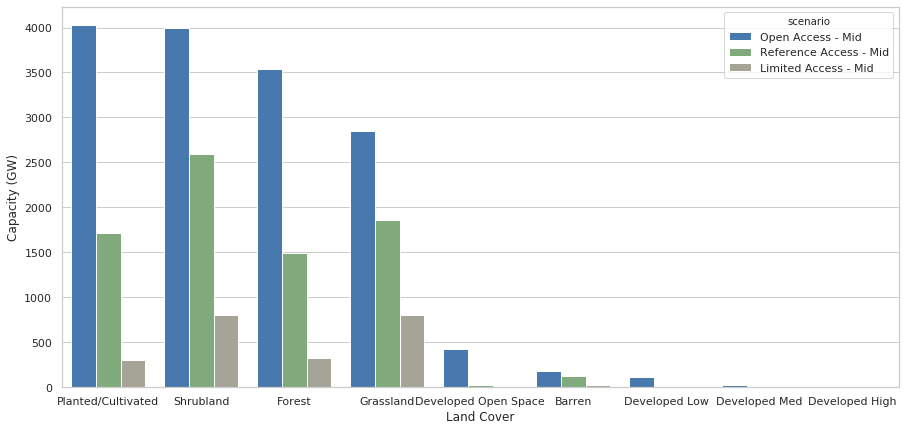

In [242]:
colors = ['windows blue', 'faded green', 'greyish']
sns.set_palette(sns.xkcd_palette(colors))

plt.figure(figsize=(15,7))

t.loc[t.scenario=='Open Access - Mid', 'order'] = 1
t.loc[t.scenario=='Reference Access - Mid', 'order'] = 2
t.loc[t.scenario=='Limited Access - Mid', 'order'] = 3

t = t[~t.land_cover_name.isin(['Water', 'Wetlands', 'Perennial Snow'])]

t = t.sort_values(by=['order', 'gw'], ascending=[True, False])

g = sns.barplot(x='land_cover_name', y='gw', hue='scenario', data=t)
    
_= g.set(ylabel='Capacity (GW)')
_= g.set(xlabel='Land Cover')

In [403]:
t = df[((df.setting!='Land-Based') & (df.scenario=='Baseline - Mid'))]

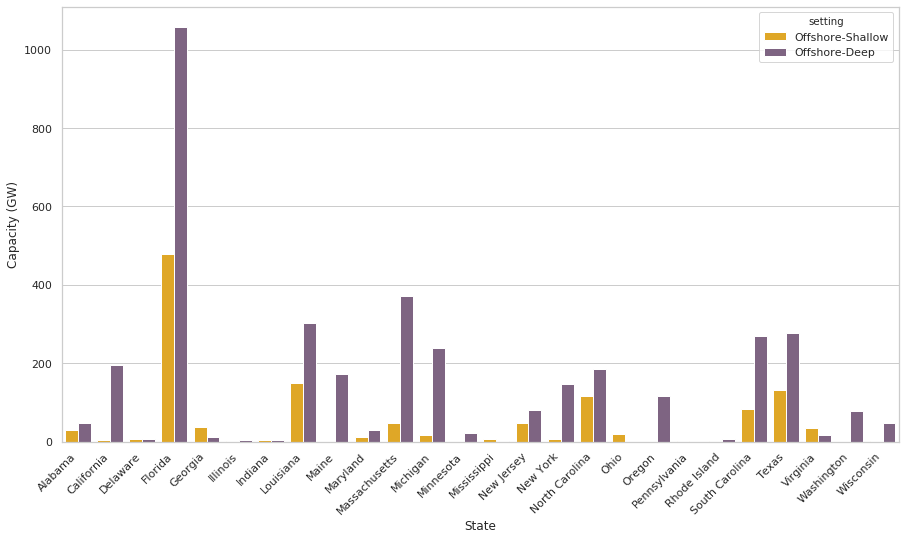

In [404]:
fig, ax = plt.subplots(figsize=(15, 8))
colors = ['amber', 'dusty purple']
sns.set_palette(sns.xkcd_palette(colors))

t = t.sort_values(by=['state'])
g = sns.barplot(x='state', y='gw', hue='setting', data=t, estimator=sum, ci=None)

_= g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
_= g.set(xlabel='State')
_= g.set(ylabel='Capacity (GW)')

In [405]:
t.groupby('setting').agg({'gw': sum})

,gw
setting,
Offshore-Deep,"3,687.60"
Offshore-Shallow,"1,234.80"


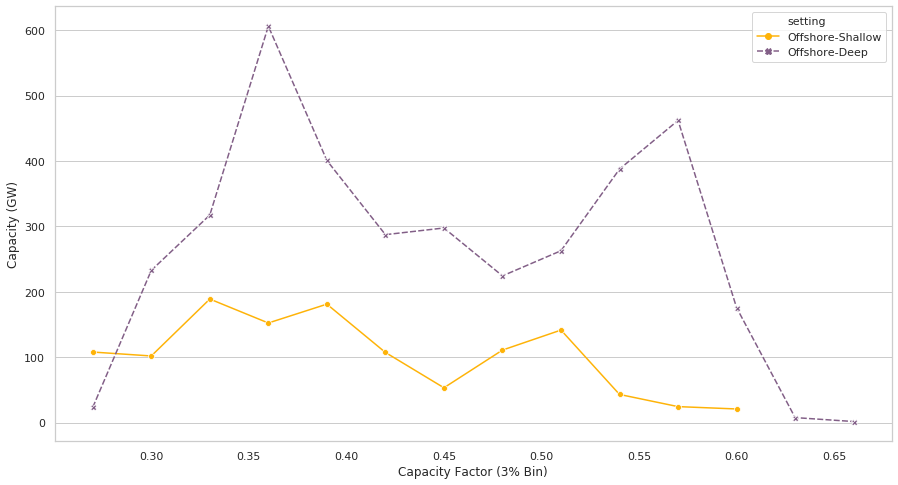

In [408]:
fig, ax = plt.subplots(figsize=(15, 8))
colors = ['amber', 'dusty purple']
sns.set_palette(sns.xkcd_palette(colors))

t['cf_bin'] = t.mean_cf.apply(lambda x: custom_round(x*100, base=3)) / 100.

sns.lineplot(x='cf_bin', y='gw', hue='setting', style='setting', markers=True,
             data=t, estimator=sum, ci=None)

_= ax.set(ylabel='Capacity (GW)')
_= ax.set(xlabel='Capacity Factor (3% Bin)')
#_= ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
_= ax.xaxis.grid(False)

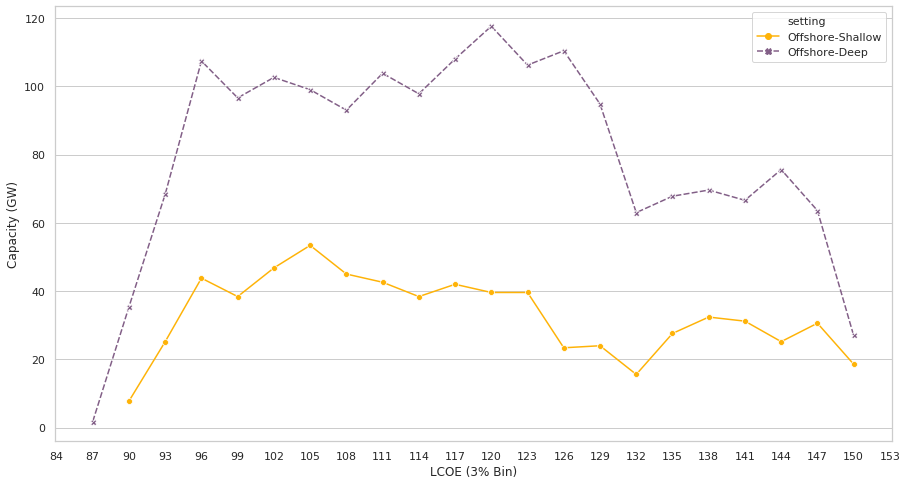

In [407]:
fig, ax = plt.subplots(figsize=(15, 8))
colors = ['amber', 'dusty purple']
sns.set_palette(sns.xkcd_palette(colors))

t['all_lcoe_bin'] = t.total_lcoe.apply(lambda x: custom_round(x, base=3))

sns.lineplot(x='all_lcoe_bin', y='gw', hue='setting', style='setting', markers=True,
             data=t[t.total_lcoe<=150], estimator=sum, ci=None)

_= ax.set(ylabel='Capacity (GW)')
_= ax.set(xlabel='LCOE (3% Bin)')
_= ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
_= ax.xaxis.grid(False)

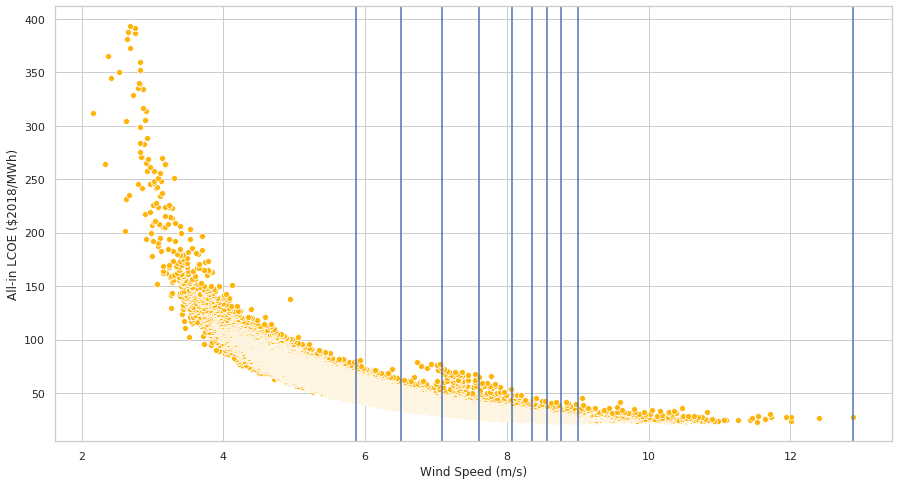

In [480]:
fig, ax = plt.subplots(figsize=(15, 8))
t = df[((df.scenario=='Baseline - Mid') & (df.total_lcoe<=400))]
g = sns.scatterplot(y='total_lcoe', x='mean_res', data=t)

plt.axvline(12.89, 0, 1, color='b')
plt.axvline(9.01, 0, 1, color='b')
plt.axvline(8.77, 0, 1, color='b')
plt.axvline(8.57, 0, 1, color='b')
plt.axvline(8.35, 0, 1, color='b')
plt.axvline(8.07, 0, 1, color='b')
plt.axvline(7.61, 0, 1, color='b')
plt.axvline(7.08, 0, 1, color='b')
plt.axvline(6.51, 0, 1, color='b')
plt.axvline(5.87, 0, 1, color='b')

_= g.set(xlabel='Wind Speed (m/s)')
_= g.set(ylabel='All-in LCOE ($2018/MWh)')